In [1]:
#!pip install openai

In [2]:
import pandas as pd
import numpy as np
from openai import OpenAI
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import os
from dotenv import load_dotenv
import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.express as px

from azure.core.credentials import AzureKeyCredential


In [ ]:
endpoint = "https://rs-aifoundry.cognitiveservices.azure.com/openai/v1/"
api_key = ""

client = OpenAI(
    base_url = endpoint,
    api_key = api_key,
)

In [4]:
def get_embedding(text, model="text-embedding-3-small"):
    """Get embedding for a given text using OpenAI API"""
    try:
        text = text.replace("\n", " ")
        response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

def create_embeddings_dataframe(df):
    """Create embeddings for each row in the dataframe"""
    print("Creating embeddings for Q&A pairs...")
    
    embeddings_list = []
    texts_list = []
    
    # Iterate through dataframe rows
    for index, row in df.iterrows():
        # Combine question and answer for better semantic representation
        combined_text = row['pergunta']
        texts_list.append(combined_text)
        print(f"{index+1} - generating embedding for: {combined_text}")
        # Get embedding
        embedding = get_embedding(combined_text)
        
        if embedding is not None:
            embeddings_list.append(embedding)
        else:
            # If API call fails, add zeros (you might want to handle this differently)
            print(f"Failed to get embedding for row {index}")
            embeddings_list.append([0] * 1536)  # text-embedding-3-small has 1536 dimensions
    
    # Create embeddings dataframe
    embeddings_df = pd.DataFrame(embeddings_list)
    
    # Add metadata columns
    embeddings_df['original_index'] = df.index
    embeddings_df['pergunta'] = df['pergunta'].values
    
    return embeddings_df

def apply_tsne(embeddings_df, embeddings_df_chats):
    """Apply t-SNE dimensionality reduction to both dataframes"""
    print("Applying t-SNE dimensionality reduction...")
    
    # Extract only the embedding columns (exclude 'pergunta')
    embedding_cols = [col for col in embeddings_df.columns if col != 'pergunta']
    
    # Extract embedding matrices from both dataframes
    embeddings_matrix_1 = embeddings_df[embedding_cols].values
    embeddings_matrix_2 = embeddings_df_chats[embedding_cols].values
    
    # Run t-SNE separately on each dataset (like the original function)
    # t-SNE for 3D - Dataset 1
    print("Reducing dataset 1 to 3D...")
    tsne_3d_1 = TSNE(n_components=3, random_state=42, perplexity=30)
    embeddings_3d_1 = tsne_3d_1.fit_transform(embeddings_matrix_1)
    
    # t-SNE for 3D - Dataset 2
    print("Reducing dataset 2 to 3D...")
    tsne_3d_2 = TSNE(n_components=3, random_state=42, perplexity=30)
    embeddings_3d_2 = tsne_3d_2.fit_transform(embeddings_matrix_2)
    
    # t-SNE for 2D - Dataset 1
    print("Reducing dataset 1 to 2D...")
    tsne_2d_1 = TSNE(n_components=2, random_state=43, perplexity=30)
    embeddings_2d_1 = tsne_2d_1.fit_transform(embeddings_matrix_1)
    
    # t-SNE for 2D - Dataset 2
    print("Reducing dataset 2 to 2D...")
    tsne_2d_2 = TSNE(n_components=2, random_state=43, perplexity=30)
    embeddings_2d_2 = tsne_2d_2.fit_transform(embeddings_matrix_2)
    
    return embeddings_3d_1, embeddings_2d_1, embeddings_3d_2, embeddings_2d_2


def apply_PCA(embeddings_df, embeddings_df_chats):
    """Apply PCA dimensionality reduction to both dataframes"""
    print("Applying PCA dimensionality reduction...")
    
    # Extract only the embedding columns using the same logic as original (exclude metadata)
    embedding_cols = []
    for name, dtype in zip(embeddings_df.columns, embeddings_df.dtypes):
        if dtype == np.float64:
            embedding_cols.append(name)
    
    # Extract embedding matrices from both dataframes
    embeddings_matrix_1 = embeddings_df[embedding_cols].values
    embeddings_matrix_2 = embeddings_df_chats[embedding_cols].values
    
    # Combine both matrices for joint dimensionality reduction
    combined_embeddings = np.vstack([embeddings_matrix_1, embeddings_matrix_2])
    
    # PCA for 3D
    print("Reducing to 3D...")
    pca_3d = PCA(n_components=3, random_state=42)
    combined_3d = pca_3d.fit_transform(combined_embeddings)
    
    # PCA for 2D
    print("Reducing to 2D...")
    pca_2d = PCA(n_components=2, random_state=42)
    combined_2d = pca_2d.fit_transform(combined_embeddings)
    
    # Split results back into separate arrays
    n_samples_1 = len(embeddings_df)
    
    embeddings_3d_1 = combined_3d[:n_samples_1]
    embeddings_3d_2 = combined_3d[n_samples_1:]
    
    embeddings_2d_1 = combined_2d[:n_samples_1]
    embeddings_2d_2 = combined_2d[n_samples_1:]
    
    # Print explained variance ratios for information
    print(f"3D PCA explained variance ratio: {pca_3d.explained_variance_ratio_}")
    print(f"3D PCA total explained variance: {pca_3d.explained_variance_ratio_.sum():.4f}")
    print(f"2D PCA explained variance ratio: {pca_2d.explained_variance_ratio_}")
    print(f"2D PCA total explained variance: {pca_2d.explained_variance_ratio_.sum():.4f}")
    
    return embeddings_3d_1, embeddings_2d_1, embeddings_3d_2, embeddings_2d_2

def create_3d_plot(embeddings_3d_1, embeddings_df, embeddings_3d_2, embeddings_df_chats, title):
    """Create interactive 3D visualization using Plotly for both dataframes"""
    
    # Create the figure
    fig = go.Figure()
    
    # Add trace for embeddings_df (blue points)
    hover_text_1 = [f"Dataset: embeddings_df<br>Pergunta: {pergunta}" 
                   for pergunta in embeddings_df['pergunta']]
    
    fig.add_trace(go.Scatter3d(
        x=embeddings_3d_1[:, 0],
        y=embeddings_3d_1[:, 1],
        z=embeddings_3d_1[:, 2],
        mode='markers',
        marker=dict(
            size=6,
            color='blue',
            opacity=0.7
        ),
        name='embeddings_df',
        text=hover_text_1,
        hovertemplate='%{text}<extra></extra>'
    ))
    
    # Add trace for embeddings_df_chats (red points)
    hover_text_2 = [f"Dataset: embeddings_df_chats<br>Pergunta: {pergunta}" 
                   for pergunta in embeddings_df_chats['pergunta']]
    
    fig.add_trace(go.Scatter3d(
        x=embeddings_3d_2[:, 0],
        y=embeddings_3d_2[:, 1],
        z=embeddings_3d_2[:, 2],
        mode='markers',
        marker=dict(
            size=6,
            color='red',
            opacity=0.7
        ),
        name='embeddings_df_chats',
        text=hover_text_2,
        hovertemplate='%{text}<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="Component 1",
            yaxis_title="Component 2",
            zaxis_title="Component 3",
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1024,
        height=768,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    fig.show()


def create_2d_plot(embeddings_2d_1, embeddings_df, embeddings_2d_2, embeddings_df_chats, title):
    """Create 2D visualization for both dataframes"""
    plt.figure(figsize=(12, 8))
    
    # Plot embeddings_df (blue points)
    plt.scatter(
        embeddings_2d_1[:, 0], 
        embeddings_2d_1[:, 1],
        label='embeddings_df', 
        alpha=0.7,
        s=50,
        color='blue'
    )
    
    # Plot embeddings_df_chats (red points)
    plt.scatter(
        embeddings_2d_2[:, 0], 
        embeddings_2d_2[:, 1],
        label='embeddings_df_chats', 
        alpha=0.7,
        s=50,
        color='red'
    )
    
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [5]:
df = pd.read_csv("scripts_dataset.csv")
df.shape

(79, 3)

In [6]:
embeddings_df = create_embeddings_dataframe(df)

Creating embeddings for Q&A pairs...
1 - generating embedding for: Quais serviços estão disponíveis nos balcões de atendimento presencial do gov.br e onde posso encontrar mais informações sobre eles?
2 - generating embedding for: Qual suporte vocês oferecem para problemas encontrados no sistema de emissão de passaportes?
3 - generating embedding for: Como faço para obter um arquivo com o registro desta conversa no chat?
4 - generating embedding for: Qual é o número de telefone para atendimento sobre assuntos relacionados ao gov.br?
5 - generating embedding for: Como posso deixar uma avaliação positiva sobre os serviços do gov.br?
6 - generating embedding for: Como posso enviar uma sugestão para a melhoria dos serviços públicos digitais do governo?
7 - generating embedding for: Como posso fazer uma reclamação sobre um serviço público federal?
8 - generating embedding for: Por que meu processo de verificação de identidade foi rejeitado ao tentar acessar o serviço online usando meu CPF?
9

In [7]:
print("Saving embeddings dataframe...")
embeddings_df.to_csv('perguntas_scripts_embeddings.csv', index=False)

Saving embeddings dataframe...


In [8]:
df_chats = pd.read_csv("perguntas_dos_chats.csv")
df_chats.shape

(101, 1)

In [9]:
embeddings_df_chats = create_embeddings_dataframe(df_chats)

Creating embeddings for Q&A pairs...
1 - generating embedding for: Como posso acessar o aplicativo fora do horário de funcionamento do suporte?
2 - generating embedding for: Como posso resolver o problema de não conseguir abrir o aplicativo gov.br no meu dispositivo?
3 - generating embedding for: Como faço para cadastrar meu INSS?
4 - generating embedding for: Como posso cadastrar uma nova conta em meu telefone?
5 - generating embedding for: Como posso desativar a verificação em duas etapas na minha conta gov.br?
6 - generating embedding for: Como posso recuperar o acesso à minha conta no aplicativo gov.br?
7 - generating embedding for: Como posso recuperar minha senha do gov.br para consultar multas de uma moto roubada?
8 - generating embedding for: Como posso resolver o problema de não conseguir entrar no aplicativo do governo?
9 - generating embedding for: Como posso recuperar minha senha durante o período de carnaval quando o atendimento está fechado?
10 - generating embedding for:

In [10]:
print("Saving embeddings chat dataframe...")
embeddings_df_chats.to_csv('perguntas_dos_chat_embeddings.csv', index=False)

Saving embeddings chat dataframe...


In [11]:
embeddings_df_chats

,0,1,2,3,4,5,6,7,8,9,...,1528,1529,1530,1531,1532,1533,1534,1535,original_index,pergunta
0,-0.029565,0.037305,0.024086,0.006900,-0.005183,-0.017488,-0.009007,0.031666,0.002723,-0.022887,...,-0.032077,0.032511,-0.012271,-0.000855,-0.021757,0.015216,0.008116,0.019246,0,Como posso acessar o aplicativo fora do horári...
1,0.014728,0.043261,0.026154,0.017697,-0.000328,-0.020001,-0.014781,-0.021952,-0.024739,0.017364,...,-0.002248,0.030934,-0.046176,-0.016614,0.015456,0.023067,-0.018576,0.015724,1,Como posso resolver o problema de não consegui...
2,0.031982,0.021581,0.009028,0.013147,0.023397,0.018824,0.015007,-0.020943,-0.026598,-0.032761,...,-0.033193,0.032998,0.001866,0.026490,0.016153,-0.010169,-0.020273,0.028241,2,Como faço para cadastrar meu INSS?
3,0.049862,0.031213,-0.018955,0.008119,0.024931,-0.024002,0.055314,-0.014184,-0.007670,-0.023015,...,-0.029079,0.025662,-0.023449,0.016821,0.018273,-0.007161,0.015903,0.016713,3,Como posso cadastrar uma nova conta em meu tel...
4,0.047082,0.015629,-0.008799,0.016602,-0.015869,0.026701,0.000326,0.019991,0.004540,0.036021,...,-0.024732,0.052394,-0.042273,0.013064,0.023655,0.008891,0.004136,0.008627,4,Como posso desativar a verificação em duas eta...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.034733,0.014043,-0.003561,0.021521,-0.041356,0.004615,-0.062486,0.044870,-0.015111,0.017877,...,-0.028916,0.001334,-0.019313,0.024667,-0.004342,0.014078,-0.009461,0.012511,96,Como posso cancelar a solicitação da CNH categ...
97,0.050130,0.024645,-0.008189,0.006659,-0.006089,0.014157,0.020125,0.033088,0.009797,0.033332,...,-0.012986,0.027629,-0.044228,-0.002301,0.026148,0.012853,0.021484,0.001128,97,Como posso desativar a verificação de duas eta...
98,0.034074,0.003459,-0.032480,0.016673,0.024736,0.024690,-0.002404,0.025806,-0.002372,-0.002070,...,-0.032024,0.030703,-0.036875,0.016547,-0.009840,0.010147,-0.006042,0.020169,98,Como posso acessar minha conta se o código de ...
99,0.061698,0.018920,-0.020600,0.034867,0.017922,0.027966,-0.015345,-0.001021,-0.002288,0.007973,...,-0.050621,0.044492,-0.034776,0.007167,0.012144,0.009420,-0.005942,0.010629,99,Como faço para desabilitar a verificação em du...


## Start from here if you already generated the embeddings 

In [6]:
embeddings_df = pd.read_csv('perguntas_scripts_embeddings.csv')
embeddings_df_chats = pd.read_csv('perguntas_dos_chat_embeddings.csv')

In [7]:
embeddings_3d_tsne_df, embeddings_2d_tsne_df, embeddings_3d_tsne_df_chats, embeddings_2d_tsne_df_chats = apply_tsne(embeddings_df, embeddings_df_chats)


Applying t-SNE dimensionality reduction...
Reducing dataset 1 to 3D...
Reducing dataset 2 to 3D...
Reducing dataset 1 to 2D...
Reducing dataset 2 to 2D...


In [8]:
embeddings_3d_pca_df, embeddings_2d_pca_df, embeddings_3d_pca_df_chats, embeddings_2d_pca_df_chats = apply_PCA(embeddings_df, embeddings_df_chats)


Applying PCA dimensionality reduction...
Reducing to 3D...
Reducing to 2D...
3D PCA explained variance ratio: [0.08208429 0.07413167 0.05737636]
3D PCA total explained variance: 0.2136
2D PCA explained variance ratio: [0.08208429 0.07413167]
2D PCA total explained variance: 0.1562


In [9]:
# # Cell 1: Install/upgrade plotly
# import sys
# !{sys.executable} -m pip install --upgrade plotly

# # Cell 2: Install notebook extensions
# !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.2"

In [10]:
pio.renderers.default = "colab"

In [11]:
create_3d_plot(
    embeddings_3d_tsne_df,
    embeddings_df,
    embeddings_3d_tsne_df_chats,
    embeddings_df_chats,
    "3D t-SNE Visualization of Embeddings")

In [12]:
create_3d_plot(
    embeddings_3d_pca_df,
    embeddings_df,
    embeddings_3d_pca_df_chats,
    embeddings_df_chats,
    "3D PCA Visualization of Embeddings")

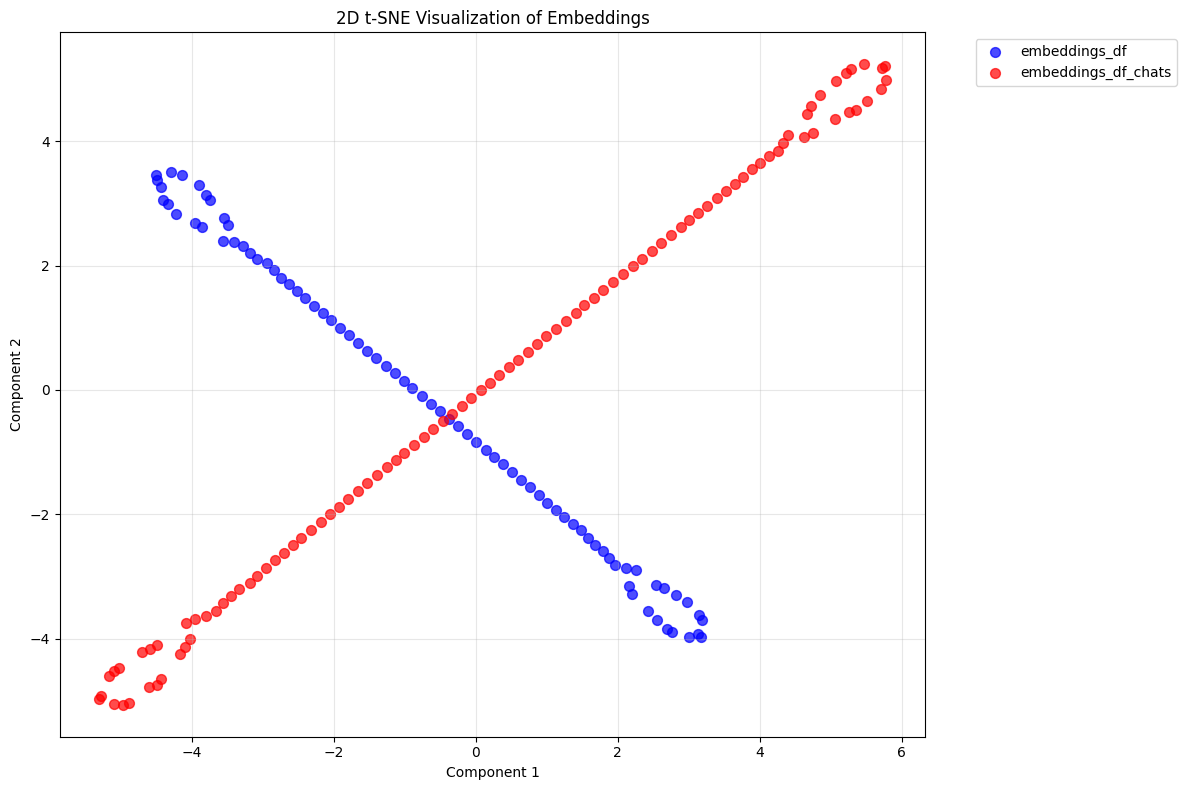

In [13]:
create_2d_plot(
    embeddings_2d_tsne_df,
    embeddings_df,
    embeddings_2d_tsne_df_chats,
    embeddings_df_chats,
    "2D t-SNE Visualization of Embeddings")

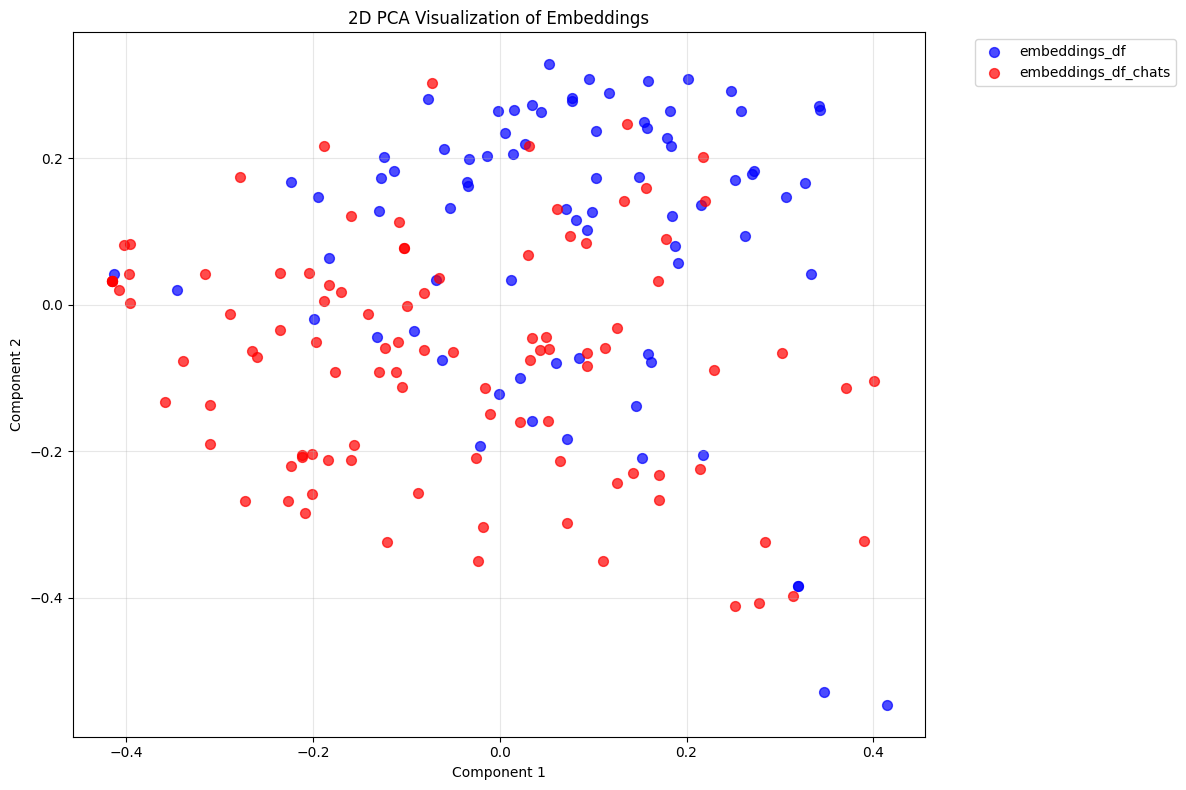

In [14]:
create_2d_plot(
    embeddings_2d_pca_df,
    embeddings_df,
    embeddings_2d_pca_df_chats,
    embeddings_df_chats,
    "2D PCA Visualization of Embeddings")